In [1]:
# did you remember to change the 'device' in general_framework.py ?
from control_framework import *
from tutorialQA_framework import *
from tutorial1_framework import *
from mem_canvas_use_framework import *
from mem_canvas_use_CHEAP_framework import *
from blue_line_QA_framework import *
from gold_direction_QA_framework import *
from near_gold_QA_framework import *
from please_turnQA_framework import *
from relpositionQA_framework import *

from temp_recorder import *

# add more here, or comment out

device = torch.device('cuda:1') # let's use the alligator GPU
#device = torch.device('cuda:0')
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=1)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

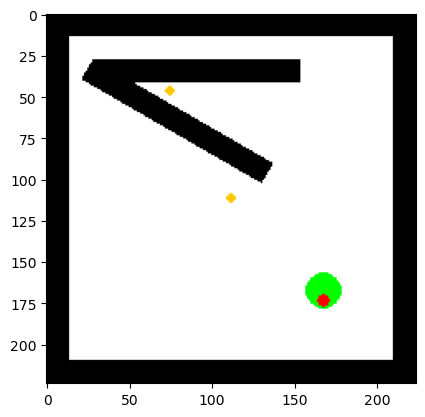

In [3]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [4]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [5]:
brain = EnhancedAgentBrain()
brain.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.

#fname = 'brain_checkpoints/enhanced_brain_first_training_batch10000.pth'
#fname = 'brain_checkpoints/enhanced_brain_first_training_v2_batch160799.pth'
#fname = 'brain_checkpoints/enhanced_brain_control_training_v1_batch16600.pth'
#fname = 'brain_checkpoints/enhanced_brain_control_training_v2_batch55900.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v1_batch1199.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v2_batch24800.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v3_batch155466.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v4_batch399.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v5_batch133.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v1_batch14250.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v2_batch29398.pth'
#fname = 'brain_checkpoints/super_brain_transferred_weights.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_v1_batch33400.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_RESTART_v1_batch31799.pth'
#fname = 'brain_checkpoints/frankenstein_transferred.pth'
#fname = 'brain_checkpoints/frankenstein_canvases_v1_batch33597.pth'
#fname = 'brain_checkpoints/frankenstein_canvases_v2_batch25999.pth'
#fname = 'brain_checkpoints/frankenstein_canvases_v3_batch19998.pth'
#fname = 'brain_checkpoints/frankenstein_tutorialQA_v2_batch9996.pth'
#fname = 'brain_checkpoints/frankenstein_tutorialQA_v6_batch10993.pth'
#fname = 'brain_checkpoints/frankenstein_tutorialQA_v8_batch13196.pth'
#fname = 'brain_checkpoints/frankenstein_blueLineDirection_v1_batch34120.pth'
#fname = 'brain_checkpoints/frankenstein_blueLineDirection_v2_batch17843.pth'
fname = 'brain_checkpoints/frankenstein_allQA_v1_batch262921.pth'

# A little extra code to avoid weird error
#brain.memory.remember(torch.randn(16, 1, 768).to(device))
brain.memory.remember(torch.randn(8, 1, 768).to(device))

brain.load_state_dict(torch.load(fname, weights_only=True, map_location=device))
brain.reset()

In [6]:
gen_optimizer = optim.Adam(brain.parameters(), lr=0.00001, eps=1e-9)
lo_lr_optimizer = optim.Adam(brain.parameters(), lr = 1e-6, eps=1e-9)

In [7]:
# should possibly also include mem_enc? Should just be gen_optimizer? 
# ONLY use this in sessions where this is the only optimizer.
# General optimizer gets messed up if this is used
#text_optimizer = optim.Adam(list(brain.text_enc.parameters()) + list(brain.text_dec.parameters()), lr=0.00001, eps=1e-9)
text_optimizer = optim.Adam(brain.text_dec.parameters(), lr=0.00001, eps=1e-9)

In [8]:
# useful to randomize the order in which the tasks are trained
class ReusableBuffer:
    def __init__(self, L, repetitions):
        self.L = []
        self.true_inds = []
        for i in range(len(L)):
            for j in range(repetitions[i]):
                self.L.append(L[i])
                self.true_inds.append(i)
        self.inds = list(range(len(self.L))) # could be longer or shorter than input L

    def draw(self, ind):
        return self.L[ind]

    def random_draw(self):
        ind_ind = random.randint(0, len(self.inds)-1)
        ind = self.inds[ind_ind]
        if ind_ind == (len(self.inds) - 1):
            self.inds = self.inds[:-1]
        else:
            self.inds = self.inds[:ind_ind] + self.inds[ind_ind + 1:]
        if len(self.inds) == 0:
            self.inds = list(range(len(self.L)))
        return self.L[ind], ind, self.true_inds[ind]

In [9]:
from gold_direction_QA_framework import *
from near_gold_QA_framework import *
from please_turnQA_framework import *
from relpositionQA_framework import *

In [10]:
# for first task (and really anywhere I want to not reset between tasks)
# make sure the batch size matches
# add further functions in the firs list, and add their repetition number to the second list
#batch_size = 16
global_batch_size = 8
default_optimizer = lo_lr_optimizer
repetitions = [8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8]
rb = ReusableBuffer([(arrow_task_batch, default_optimizer, global_batch_size), \
                     (qa_task_batch, default_optimizer, global_batch_size), \
                     (qa_task_batch, text_optimizer, 2*global_batch_size), \
                     (control_batch, default_optimizer, global_batch_size), \
                     (mem_canvas_batch, default_optimizer, 6), \
                     (mem_canvas_CHEAP_batch, default_optimizer, global_batch_size),
                     (blue_line_direction_batch, default_optimizer, global_batch_size),
                     (gold_direction_batch, default_optimizer, global_batch_size),
                     (gold_proximity_batch, default_optimizer, global_batch_size),
                     (please_turn_batch, default_optimizer, global_batch_size),
                     (relposition_qa_batch, default_optimizer, global_batch_size)], \
                    repetitions)

In [11]:
batches = [0 for x in repetitions]

In [12]:
curr_mins = [1.0e6 for x in repetitions]

In [13]:
total_losses = [0 for x in repetitions]

In [14]:
#torch.autograd.set_detect_anomaly(True)

In [15]:
import warnings
# I'll find the place that causes the 'non in-place resize later; for now, I don't want to clutter the results'
warnings.filterwarnings('ignore')

In [16]:
total_batches = 10000*100#6250*32

for b in range(total_batches):
    secs_to_cool = monitor_stage(device)
    if secs_to_cool > 0:
        print(f"Had to cool device for {secs_to_cool} seconds\n")
        
    triplet, _, ind = rb.random_draw()
    func, opt, batch_size = triplet
    
    batch_num = batches[ind]
    batches[ind] += 1

    #reset_model = True #default option; only transfer memory within the task files
    reset_model = (b % 3 == 2)
    if batch_size != global_batch_size:
        brain.reset() # prevents bad memory and canvas problems; do this before and after calling func

    printing = ((batch_num % 100) == 99)
    full_results = func(batch_size, brain, optimizer=opt, batch_num=batch_num, compute_grad=True, random_order=True, model_eval=False, reset_model=reset_model, printing=printing, training=True)
    L = full_results[0] # no need to look into the detailed loss report
    total_losses[ind] += L

    if batch_size != global_batch_size:
        brain.reset() # prevents bad memory and canvas problems
    
    if printing: # if this is a significant batch
        avg_loss = total_losses[ind] / 100
        total_losses[ind] = 0
        print(f"Average total loss for task {ind}, last 100 batches: {avg_loss}\n=================================================\n\n\n")
        
        if avg_loss < curr_mins[ind]:
            curr_mins[ind] = avg_loss
            print(f"Saving at batch {b + 1}\n=======================================\n\n\n")
            torch.save(brain.state_dict(), f"brain_checkpoints/frankenstein_allQA_v2_batch{b + 1}.pth")
            
    if b < 10:
        print(f"batch {b}, task {ind}, task batch_num {batch_num}\n")

batch 0, task 4, task batch_num 0

batch 1, task 0, task batch_num 0

batch 2, task 0, task batch_num 1

batch 3, task 7, task batch_num 0

batch 4, task 3, task batch_num 0

batch 5, task 9, task batch_num 0

batch 6, task 6, task batch_num 0

batch 7, task 0, task batch_num 2

batch 8, task 4, task batch_num 1

batch 9, task 10, task batch_num 0

Total loss: 0.0030960706062614918; that's 0.0017711077816784382 task and 0.00035050298902206123 recon and 4.872298717498779 total text


Average total loss for task 0, last 100 batches: 0.003414633919019252



Saving at batch 369



Total loss: 0.004086875822395086; that's 0.002981006633490324 task and 0.00033950962824746966 recon and 3.8317978382110596 total text


Average total loss for task 0, last 100 batches: 0.004131645883899182



Total loss: 4.260453701019287:
3.301358222961426 control,
0.959095299243927 recognizing the blue line direction


Average total loss for task 6, last 100 batches: 4.346334059238433



Saving at batch 1065




KeyboardInterrupt: 

In [ ]:
# Updates: add sampling weights; add batch_num to print statement; split these two optimizers and optimize them separately